In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Importing required libraries

In [2]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle
import numpy

import copy

import pylab

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


# Viewing the raw LIGO data

In [3]:
# For Single Template Model

# Storing the file name
gw170817_file_names = {}

# To store Power Spectral Density
psds = {}

# To store data
gw170817 = {}

In [4]:
merger_gw170817 = Merger("GW170817")

# LIGO Observatories
ifos = ['H1', 'V1', 'L1']

for ifo in ifos:
    
    print("Downloading: {} dataset".format(ifo))
    
    # Downloading the gravitational wave data for GW170817
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"

    file_name = download_file(url.format(ifo[0], ifo[0]), cache = True)
    
    # Storing the file name
    gw170817_file_names[ifo] = file_name
    
    # Storing the data itself
    gw170817[ifo] = read_frame(file_name, "{}:LOSC-STRAIN".format(ifo), start_time = int(merger_gw170817.time - 260), end_time = int(merger_gw170817.time + 40))

Downloading: H1 dataset
Downloading: V1 dataset
Downloading: L1 dataset


## Plotting Entire 300 seconds of data around GW170817

In [5]:
# def plot_gravitational_waves(ifos, gw_merger):
    
#     pylab.figure(figsize = (20, 5))

#     for ifo in ifos:
#         pylab.plot(gw_merger[ifo].sample_times, gw_merger[ifo], label = ifo)

#         pylab.ylabel('Strain')
#         pylab.xlabel('GPS Time (s)')
#         pylab.legend()
        
#     pylab.show()

In [6]:
# plot_gravitational_waves(ifos, gw170817)

# Removing low frequency content and resampling the data

**We apply highpass filter to the signal at 15Hz.<br>Applying high pass filter is used for removing low frequency content from a signal.**

**Gravitational waves have higher frequencies than most of the noise, so by filtering out low frequencies, we can enhance the signal-to-noise ratio of the gravitational wave.**

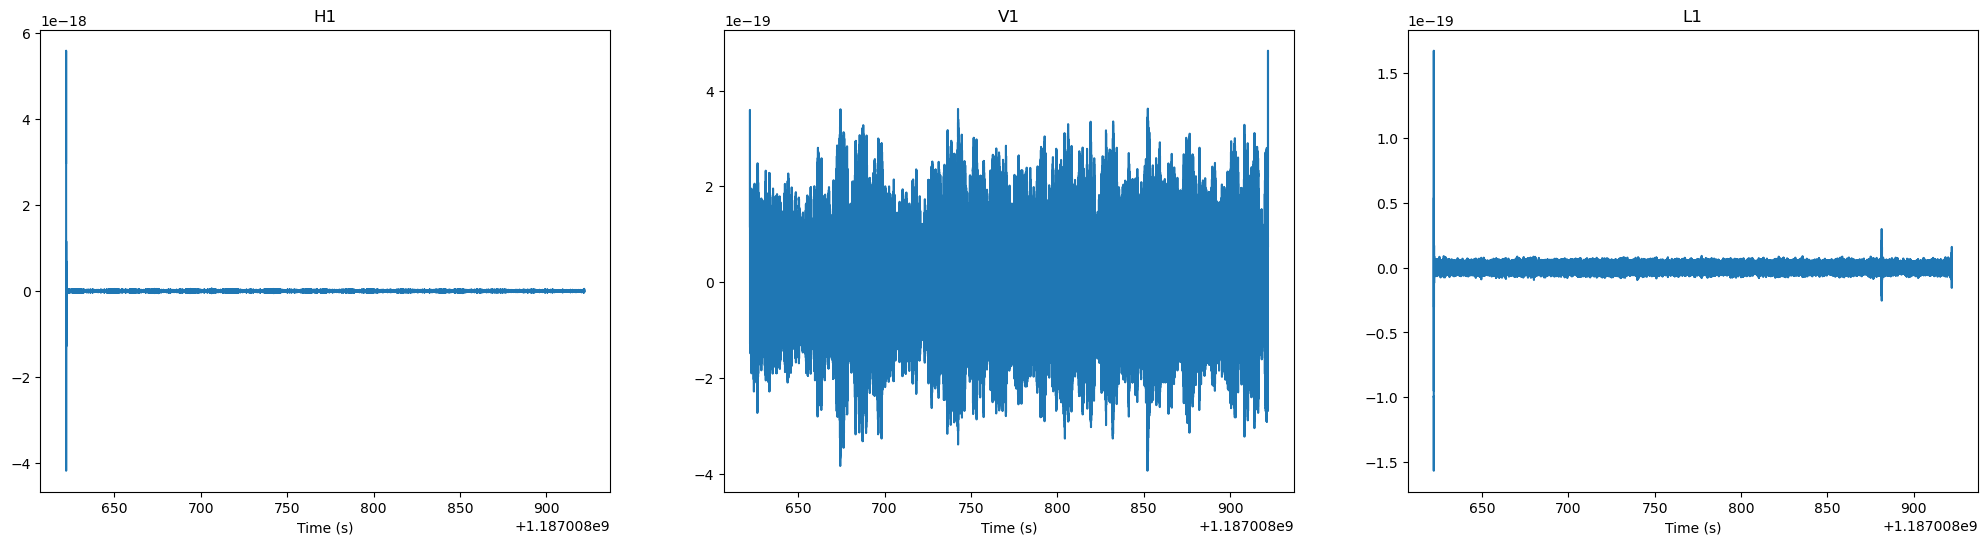

In [7]:
gw170817_highpass_resampled = {}

fig, ax = pylab.subplots(1, 3, figsize = (25, 6))

for i, ifo in zip(range(len(ifos)), ifos):
    
    # Applying HighPass Filter: Frequencies below 15Hz are removed.
    gw170817_highpass = highpass(gw170817[ifo], 15.0)
    
    # Resampling to delta_t: Used to adjust sampling rate of gravitational wave data from each detectors.
        # It makes the data from different detectors have same time step which allows us to compare data between detectors.
    gw170817_highpass_resampled[ifo] = resample_to_delta_t(gw170817_highpass, 1.0/2048)
    
    # Plotting the resampled timeseries
    ax[i].plot(gw170817_highpass_resampled[ifo].sample_times, gw170817_highpass_resampled[ifo])
    ax[i].set_xlabel('Time (s)')
    ax[i].set_title(ifo)

pylab.show()

**The spike is caused by the high pass and resampling stages filtering of the data.<br>When the filter is applied to boundaries, it wraps around the beginning of the data.<br>Since the data has the discontinuity the filter itself will ring off for a time up to the length of the filter.**

**To avoid it we can crop 2 seconds of data from both the beginning and the end.**

In [8]:
# gw170817_highpass_croped = {}

# fig, ax = pylab.subplots(1, 3, figsize = (25, 6))

# for i, ifo in zip(range(len(ifos)), ifos):
#     gw170817_highpass_croped[ifo] = gw170817_highpass_resampled[ifo].crop(2, 2)
    
#     ax[i].plot(gw170817_highpass_croped[ifo].sample_times, gw170817_highpass_croped[ifo])
#     ax[i].set_xlabel('Time (s)')
#     ax[i].set_title(ifo)

# pylab.show()

# Power Spectral Density

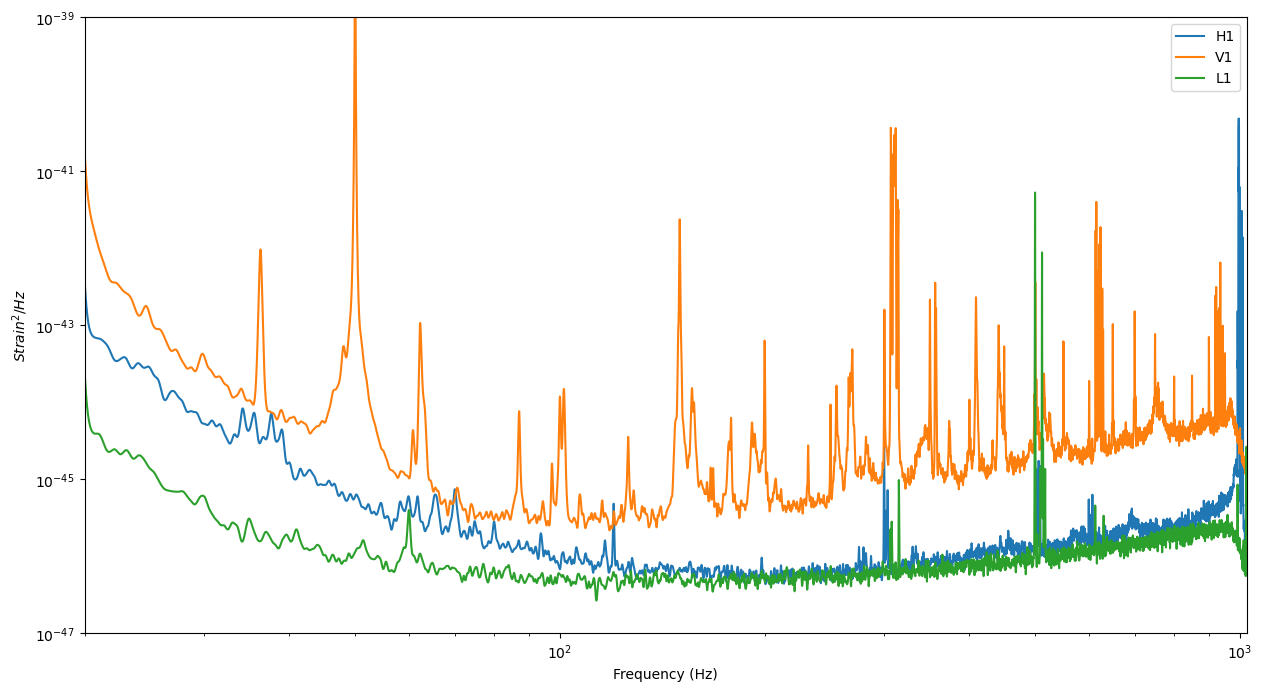

In [9]:
gw170817_interpolate = {}
gw170817_psd = {}

pylab.figure(figsize = (15, 8))

for ifo in ifos:
    
    # Limiting the time around the signal
    gw170817_highpass_resampled[ifo] = gw170817_highpass_resampled[ifo].time_slice(merger_gw170817.time - 112, merger_gw170817.time + 16)
    
    # Convert to a frequency series by taking the data's FFT and storing it in gw170817 series
    gw170817[ifo] = gw170817_highpass_resampled[ifo].to_frequencyseries()
    
    # Interpolate: Process of estimating the a new PSD value at a frequency that is not explicitly included in the original PSD.
    # Offers high resolution (provides more detailed information about the freq content in the signal), reduces noise and statistical fluctutations in the data.
    gw170817_interpolate[ifo] = interpolate(gw170817_highpass_resampled[ifo].psd(4), gw170817_highpass_resampled[ifo].delta_f)
    
    # inverse_spectrum_truncation: It is used to mitigate the effects of non-stationary noise in the data.
    gw170817_psd[ifo] = inverse_spectrum_truncation(gw170817_interpolate[ifo], int(4 * gw170817_interpolate[ifo].sample_rate), trunc_method = "hann", low_frequency_cutoff = 20.0)
    
    psds[ifo] = gw170817_psd[ifo]
    
    pylab.loglog(gw170817_psd[ifo].sample_frequencies, gw170817_psd[ifo], label = ifo)
    pylab.ylabel('$Strain^2 / Hz$')
    pylab.xlabel('Frequency (Hz)')
    
    pylab.ylim(1e-47, 1e-39)
    pylab.xlim(20, 1024)
    
    pylab.legend()

pylab.show()

**Spikes in the above graph indicates the presence of noise at specific frequencies for each detectors.**

**Not all peaks in the above graph are due to noise. Some may due to presence of gravitational waves.**

# Visualizing the Gravitational Wave

In [10]:
# import matplotlib.pyplot as pp
# import pycbc.catalog


# m = pycbc.catalog.Merger("GW170817", source='gwtc-1')

# fig, axs = pp.subplots(2, 1, sharex=True, sharey=True)

# for ifo, ax in zip(["L1", "H1"], axs):
#     pp.sca(ax)
#     pp.title(ifo)
    
#     # Retreive data around the BNS merger
#     ts = m.strain(ifo).time_slice(m.time - 15, m.time + 6)

#     # Whiten the data with a 4s filter
#     white = ts.whiten(4, 4)

#     times, freqs, power = white.qtransform(.01, logfsteps=200,
#                                         qrange=(110, 110),
#                                         frange=(20, 512))
#     pp.pcolormesh(times, freqs, power**0.5, vmax=5)

# pp.yscale('log')
# pp.ylabel("Frequency (Hz)")
# pp.xlabel("Time (s)")
# pp.show()

# Single Template Model

**It is a search method that uses a single pre-defined waveform template to match against our data.**

**Model requires a specific set of data products:<br><li>Dictionary of frequency-domain data</li><li>Dictionary of Power Spectral Density estimates</li><li>Low frequency cutoff to use for internal filtering in the model.</li>**

## Dictionary of frequency-domain data

In [11]:
gw170817

{'H1': <pycbc.types.frequencyseries.FrequencySeries at 0x7fa439c43670>,
 'V1': <pycbc.types.frequencyseries.FrequencySeries at 0x7fa4395c2c10>,
 'L1': <pycbc.types.frequencyseries.FrequencySeries at 0x7fa43999cd60>}

## Dictionary of Power Spectral Density

In [12]:
psds

{'H1': <pycbc.types.frequencyseries.FrequencySeries at 0x7fa439a04760>,
 'V1': <pycbc.types.frequencyseries.FrequencySeries at 0x7fa4395d1d00>,
 'L1': <pycbc.types.frequencyseries.FrequencySeries at 0x7fa4399a3e20>}

## Static Parameters

**These are the parameters that do not change.**

In [13]:
static_parameters = {
    'mass1':1.3757,
    'mass2':1.3757,
    'f_lower':25.0,
    'approximant':"TaylorF2",
    'polarization':0,
    'ra': 3.44615914,
    'dec': -0.40808407
}

## Variable Parameters

**These parameters vary**

In [14]:
variable_parameters = (
    'distance',
    'inclination',
    'tc'
)

## Prior

In [16]:
inclination_prior = SinAngle(inclination=None)
distance_prior = Uniform(distance=(10, 100))
tc_prior = Uniform(tc=(merger_gw170817.time - 0.1, merger_gw170817.time + 0.1))

prior = JointDistribution(variable_parameters, inclination_prior, distance_prior, tc_prior)

## Setting out the Model

In [17]:
model = models.SingleTemplate(variable_parameters, copy.deepcopy(gw170817),
                              low_frequency_cutoff={'H1':25, 'L1':25, 'V1':25},
                              psds = psds,
                              static_params = static_parameters,
                              prior = prior,
                              sample_rate = 8192,
                              )

## Setting up the Sampler

In [ ]:
smpl = sampler.EmceePTSampler(model, 3, 200, nprocesses=8)

## Setting the starting point

In [ ]:
_ = smpl.set_p0() # If we don't set p0, it will use the models prior to draw initial points!

## Running the sampler

In [18]:
# Note it may take ~1-3 minutes for this to run
smpl.run_mcmc(200)

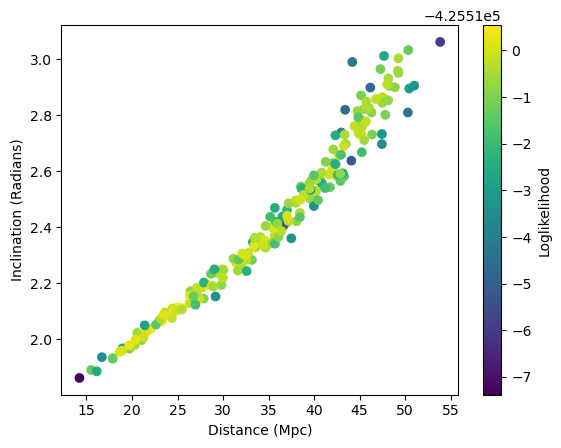

In [19]:
lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Note how we have to access the arrays differently that before since there is an additional dimension. 
# The zeroth element of that dimension represents the 'coldest' and is the one we want for our results.
# The other temperatures represent a modified form of the likelihood that allows walkers to traverse
# the space more freely.
pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

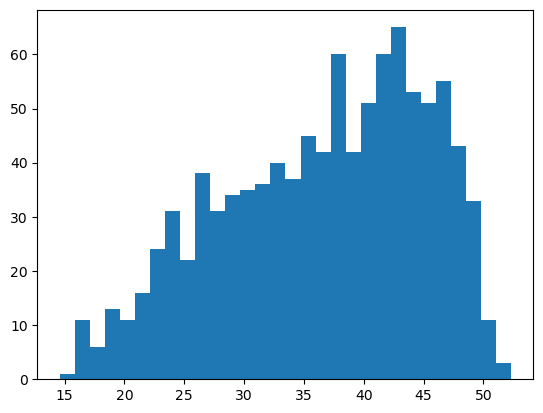

In [20]:
_ = pylab.hist(s['distance'][0,:,-100::20].flatten(), bins=30)

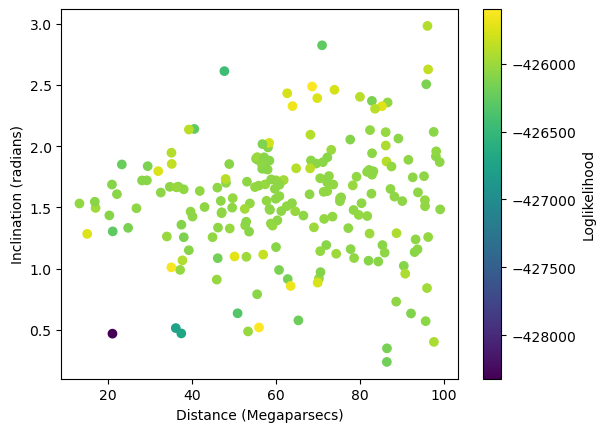

In [21]:
%matplotlib inline
from matplotlib import animation
import pylab

# We'll plot the initial position of the walkers
fig = pylab.figure(10)
a = pylab.scatter(s['distance'][0,:,0],
                  s['inclination'][0,:,0],
                  c=lik[0,:,0])
pylab.xlabel('Distance (Megaparsecs)')
pylab.ylabel('Inclination (radians)')
c = pylab.colorbar()
c.set_label('Loglikelihood')

# This function will update the plot with the ith iteration of our mcmc chain.
def animate(i):
    dat = numpy.array([s['distance'][0,:,i], s['inclination'][0,:,i]])
    a.set_offsets(dat.T)
    a.set_array(lik[0,:,i])
    return (a, )
    
nsamples = len(s['distance'][0,0,:])
ani = animation.FuncAnimation(fig, animate, frames=nsamples,
                              interval=200, blit=True)

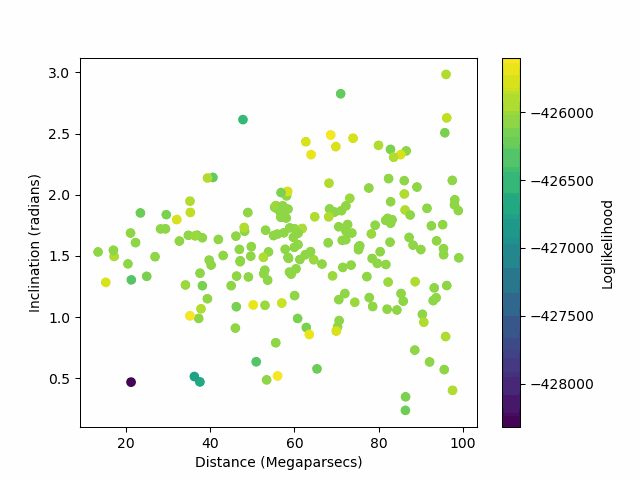

In [22]:
from matplotlib.animation import PillowWriter
from IPython.display import Image

# Note to get this to play, you may need to right click on the image and
# download to your computer or open the image in a new tab of your browser
ani.save('move.gif', writer=PillowWriter(fps=5))
with open('move.gif','rb') as f:
    display(Image(data=f.read(), format='png'))